In [1]:
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


<p>Building a recall/precision function.</p>

In [2]:
def prec_recall(df):
    '''Assumes columns of pred and label'''
    tp=df[(df['label']==1)&(df['pred']==1)].shape[0]#number of true positives
    recall = tp/df['label'].sum()                   #recall
    prec =   tp/df['pred'].sum()                    #precision
    fp=df[(df['label']!=1)&(df['pred']==1)].shape[0]#number of false positives
    fpr=fp/df['pred'].sum()                         #False positive rate
    return prec,recall,fpr

<p>Opening normalized credit card data.</p>

In [3]:
fn="creditcard_cleaned.csv"
df=pd.read_csv(fn)

In [4]:
cols=[col for col in df.columns if col not in ["Class"]]

<p>Removing a test set.</p>

In [5]:
dftrain,dftest=train_test_split(df,test_size=0.15)

In [6]:
numinps= len(cols)
numinps

30

<p>Test/Train split for train and eval data.</p>

In [7]:
dftrain2,dfeval=train_test_split(dftrain,test_size=0.15)

<p>Building a 5 layer DNN starting at 8*number of inputs and ending with number of inputs.</p>

In [8]:
encodedim=28
numclasses=2
hiddim=encodedim//2
lr=0.001 #learnrate=tf.placeholder(tf.float32, name='learningrate')
droprate=0.2 #tf.placeholder(tf.float32, name='droprate')
inputs=tf.placeholder(tf.float64, shape=(None,numinps),name="inputs")
mode=tf.placeholder(tf.string, name="mode")
labels=tf.placeholder(tf.int32,shape=(None),name='labels')

dense0 = tf.layers.dense(inputs=inputs, units=numinps*8, activation=tf.nn.relu)
dropout0 = tf.layers.dropout(inputs=dense0, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense1 = tf.layers.dense(inputs=dropout0, units=numinps*4, activation=tf.nn.relu)
dropout1 = tf.layers.dropout(inputs=dense1, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense1a = tf.layers.dense(inputs=dropout1, units=numinps*3, activation=tf.nn.relu)
dropout1a = tf.layers.dropout(inputs=dense1a, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense2 = tf.layers.dense(inputs=dropout1a, units=numinps*2, activation=tf.nn.relu)
dropout2 = tf.layers.dropout(inputs=dense2, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense3 = tf.layers.dense(inputs=dropout2, units=numinps*1, activation=tf.nn.relu)
dropout3 = tf.layers.dropout(inputs=dense3, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense4 = tf.layers.dense(inputs=dropout3, units=numclasses)#, activation=tf.nn.relu)
logits = tf.layers.dropout(inputs=dense4, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)
Yprobab=tf.nn.softmax(logits,name='Yprobab')
Yout = tf.argmax(Yprobab,1)

#loss=tf.losses.mean_squared_error(labels=inputs,predictions=dropout4)
#loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=labels)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=labels)
batchloss=tf.reduce_mean(loss)
trainstep=tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)


<p>Training model with training data and evaluating on evaluation set every 5 steps or so.  Then at the end, I make predictions using my test set.  Result processed into precision and recell below.</p>

In [9]:
init = tf.global_variables_initializer()
batchsize=100
#xbatch=dftrain2.loc[:,cols].head(10).values
evalbatch=dfeval[cols]
evallabels=dfeval["Class"]
numepochs=1

treerr=[]
everr=[]

report_it=50
eval_it=report_it*5

with tf.Session() as sess:
    
    sess.run(init)
    for epoch in range(numepochs):
        for i in range(dftrain2.shape[0]//batchsize):
            xbatch=dftrain2.iloc[i*batchsize:(i+1)*batchsize][cols].values
            lab=dftrain2.iloc[i*batchsize:(i+1)*batchsize]['Class']
            _,ltr=sess.run([trainstep,batchloss],feed_dict={inputs:xbatch,labels:lab})#,learnrate:0.001,droprate:0.2,mode:tf.estimator.ModeKeys.TRAIN})
            if i%(eval_it//5)==0:
                l=sess.run([batchloss],feed_dict={inputs:evalbatch,labels:evallabels})#,learnrate:0.001,droprate:0.2,mode:tf.estimator.ModeKeys.EVAL})
                treerr.append(ltr)
                everr.append(l)
            
            if i%report_it==0 and i>0:
                print("train: ",epoch,i,ltr)
            if i%eval_it==0  and i>0:
                print("evalu: ",epoch,i,l[0])
    print("evalu: ",epoch,i,l[0])
    
    print("Running Test data...")
    #out=[]
    if 1:
    #for i in range(dftest.shape[0]):
        testbatch=np.array(dftest.iloc[:][cols].values)
        testlabels=np.array(dftest.iloc[:]['Class'].values)
        l,yout=sess.run([batchloss,Yout],feed_dict={inputs:testbatch,labels:testlabels})#,learnrate:0.001,droprate:0.2,mode:tf.estimator.ModeKeys.EVAL})
        #out.append()
        dfout2=pd.DataFrame(data={"label":dftest.iloc[:]['Class'].values,"err":l,"pred":yout})
    tf.saved_model.simple_save(sess,"./m", inputs=
                           {
                               "inputs":inputs#,'labels':labels,"learnrate":learnrate,"droprate":droprate,"mode":mode
                           },
                           outputs={"Yout":Yout}#,"batchloss":batchloss}
                          )

train:  0 50 0.0033996984188137537
train:  0 100 0.0002813698318440727
train:  0 150 0.0002596509907660079
train:  0 200 0.0004213052011649633
train:  0 250 6.962394241946464e-05
evalu:  0 250 0.005073468889649064
train:  0 300 0.00017317563179673377
train:  0 350 0.001975134493505602
train:  0 400 0.04091897730344543
train:  0 450 0.019070305691122044
train:  0 500 0.00020965429133818926
evalu:  0 500 0.004479661125457458
train:  0 550 0.00032611751199973846
train:  0 600 5.933355718023318e-05
train:  0 650 8.34177582832727e-06
train:  0 700 0.0001362326834440386
train:  0 750 3.7309916853337214e-06
evalu:  0 750 0.005743423005699536
train:  0 800 0.0003055430300264936
train:  0 850 0.07900509715420202
train:  0 900 0.0010354886650109233
train:  0 950 0.0003834109782858326
train:  0 1000 0.010997815097533366
evalu:  0 1000 0.0037571358364429067
train:  0 1050 0.002616750550508773
train:  0 1100 0.00013611527554172482
train:  0 1150 0.00013935172630046995
train:  0 1200 0.0805493085399

<p>Plotting training and evaluation error.</p>

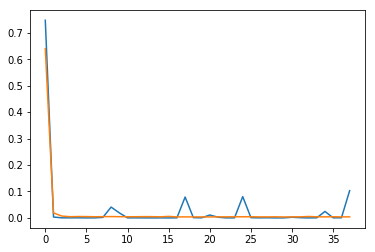

In [10]:
plt.plot(treerr)
plt.plot(everr)
plt.show()

<p>Calculating precision and recal on final test dataset.</p>

In [11]:
prec2,recall2,fpr2=prec_recall(dfout2)
print("DNNClassifier prec {:5.3f}, recall {:5.3f}, fpr {:5.3f}".format(prec2,recall2,fpr2))

DNNClassifier prec 0.875, recall 0.789, fpr 0.125


<p>Printinf string listing columns in the format needed for the flogo.json file</p>

In [12]:
l=[]
for col in cols:
    l.append('"=$.result.{:s}"\n'.format(col))
s=','.join(l)
print(s)

"=$.result.V1"
,"=$.result.V2"
,"=$.result.V3"
,"=$.result.V4"
,"=$.result.V5"
,"=$.result.V6"
,"=$.result.V7"
,"=$.result.V8"
,"=$.result.V9"
,"=$.result.V10"
,"=$.result.V11"
,"=$.result.V12"
,"=$.result.V13"
,"=$.result.V14"
,"=$.result.V15"
,"=$.result.V16"
,"=$.result.V17"
,"=$.result.V18"
,"=$.result.V19"
,"=$.result.V20"
,"=$.result.V21"
,"=$.result.V22"
,"=$.result.V23"
,"=$.result.V24"
,"=$.result.V25"
,"=$.result.V26"
,"=$.result.V27"
,"=$.result.V28"
,"=$.result.TimeSN"
,"=$.result.AmountSN"

